# Going Deeper -- the Mechanics of PyTorch


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image

## The key features of PyTorch

## PyTorch's computation graphs

### Understanding computation graphs


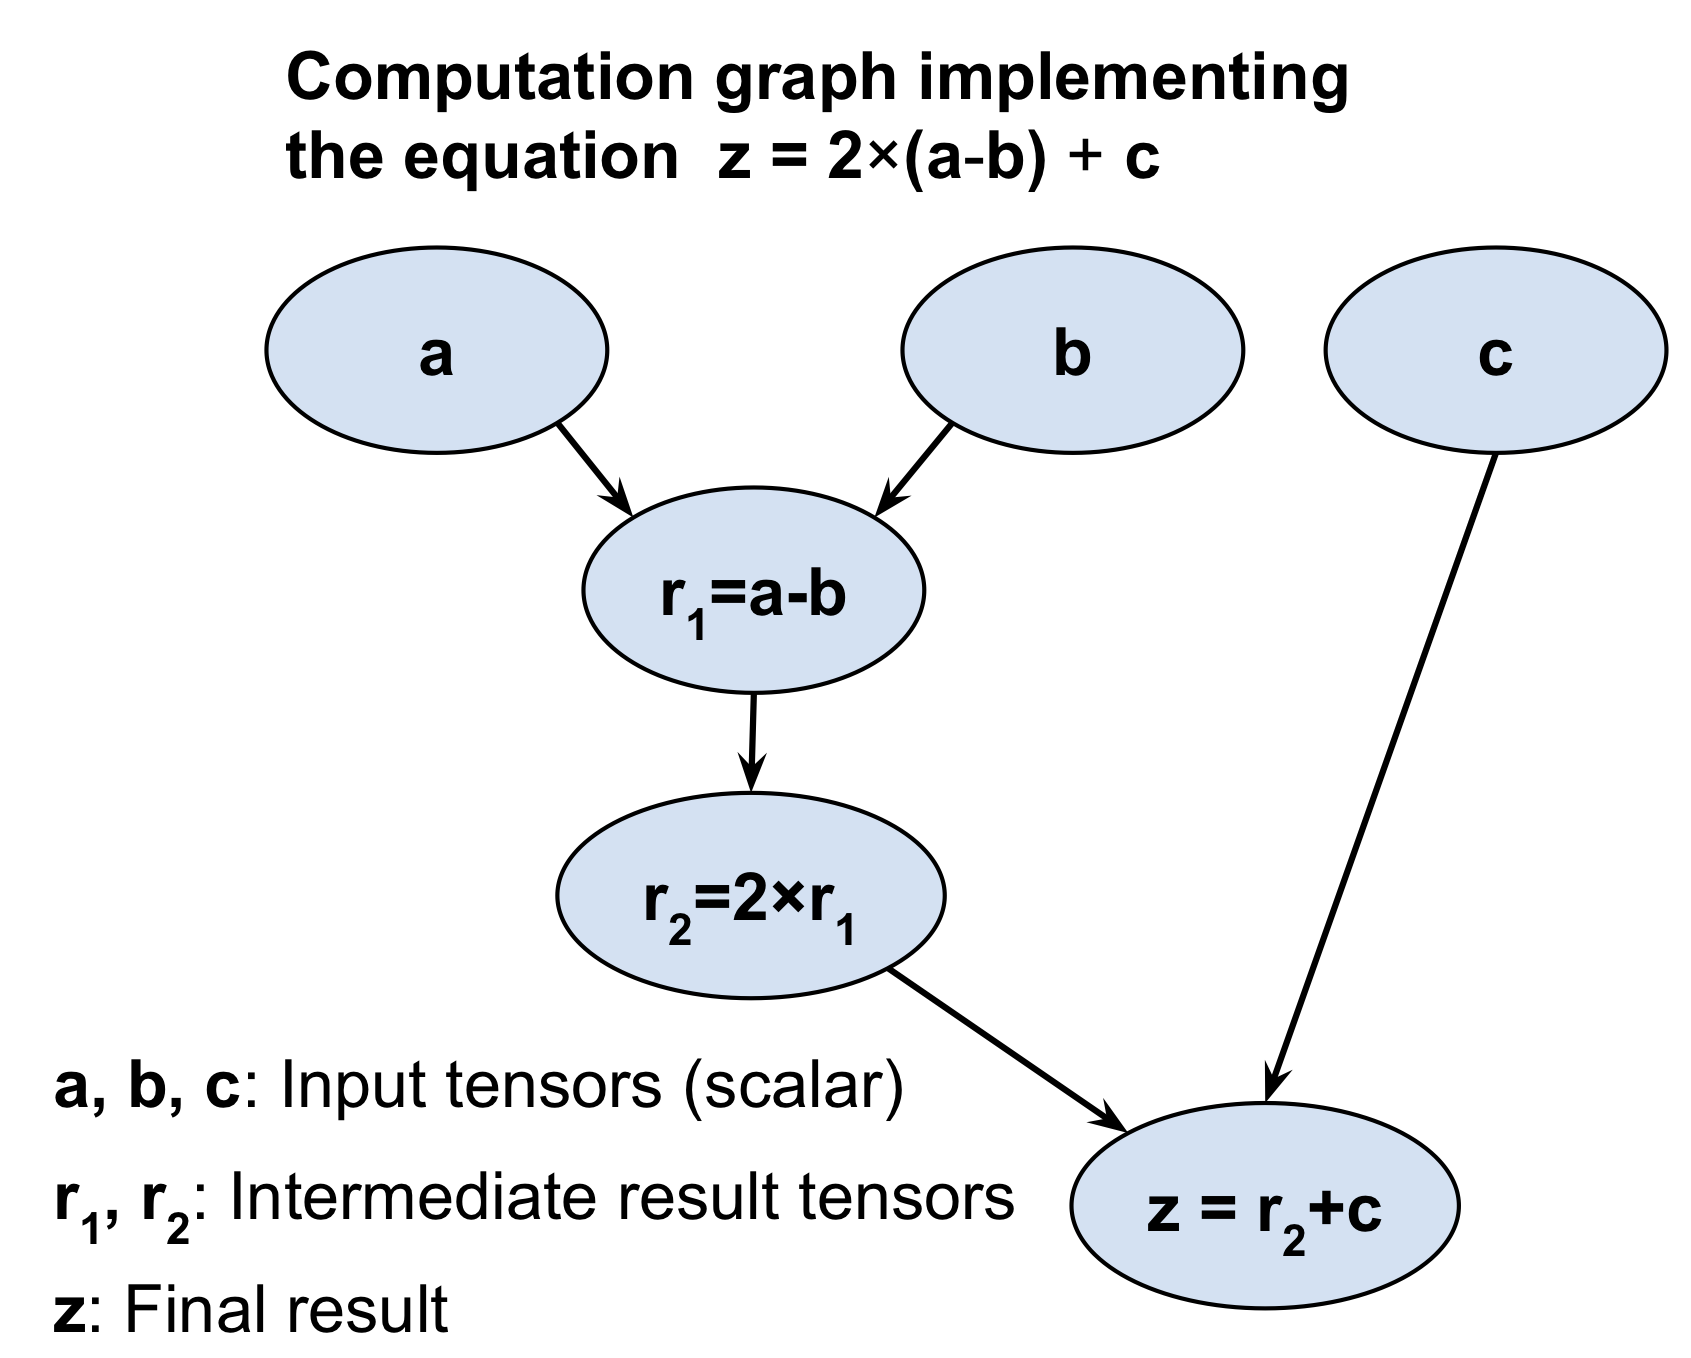

In [2]:
Image(filename='figures/13_01.png', width=400)

### Creating a graph in PyTorch


In [3]:
import torch

In [4]:
def compute_z(a, b, c):
    r1 = torch.sub(a, b)
    r2 = torch.mul(r1, 2)
    z = torch.add(r2, c)
    return z


print('Scalar Inputs:',
      compute_z(torch.tensor(1), torch.tensor(2), torch.tensor(3)))
print('Rank 1 Inputs:',
      compute_z(torch.tensor([1]), torch.tensor([2]), torch.tensor([3])))
print('Rank 2 Inputs:',
      compute_z(torch.tensor([[1]]), torch.tensor([[2]]), torch.tensor([[3]])))


Scalar Inputs: tensor(1)
Rank 1 Inputs: tensor([1])
Rank 2 Inputs: tensor([[1]])


## PyTorch Tensor objects for storing and updating model parameters


In [5]:
a = torch.tensor(3.14, requires_grad=True)
b = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
print(a)
print(b)

tensor(3.1400, requires_grad=True)
tensor([1., 2., 3.], requires_grad=True)


In [6]:
a.requires_grad

True

In [7]:
w = torch.tensor([1.0, 2.0, 3.0])

print(w.requires_grad)

False


In [8]:
w.requires_grad_()

print(w.requires_grad)

True


In [9]:
import torch.nn as nn

torch.manual_seed(1)
w = torch.empty(2, 3)
nn.init.xavier_normal_(w)
print(w)


tensor([[ 0.4183,  0.1688,  0.0390],
        [ 0.3930, -0.2858, -0.1051]])


In [10]:
class MyModule(nn.Module):

    def __init__(self):
        super().__init__()
        self.w1 = torch.empty(2, 3, requires_grad=True)
        nn.init.xavier_normal_(self.w1)
        self.w2 = torch.empty(1, 2, requires_grad=True)
        nn.init.xavier_normal_(self.w2)


## Computing gradients via automatic differentiation and GradientTape


### Computing the gradients of the loss with respect to trainable variables


In [11]:
w = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(0.5, requires_grad=True)

x = torch.tensor([1.4])
y = torch.tensor([2.1])

z = torch.add(torch.mul(w, x), b)

loss = (y - z).pow(2).sum()
loss.backward()

print('dL/dw : ', w.grad)
print('dL/db : ', b.grad)


dL/dw :  tensor(-0.5600)
dL/db :  tensor(-0.4000)


In [12]:
# verifying the computed gradient dL/dw
print(2 * x * ((w * x + b) - y))

tensor([-0.5600], grad_fn=<MulBackward0>)


## Simplifying implementations of common architectures via the torch.nn module


### Implementing models based on nn.Sequential


In [13]:
model = nn.Sequential(nn.Linear(4, 16), nn.ReLU(), nn.Linear(16, 32),
                      nn.ReLU())

model

Sequential(
  (0): Linear(in_features=4, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=32, bias=True)
  (3): ReLU()
)

#### Configuring layers

- Initializers `nn.init`: https://pytorch.org/docs/stable/nn.init.html
- L1 Regularizers `nn.L1Loss`: https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html#torch.nn.L1Loss
- L2 Regularizers `weight_decay`: https://pytorch.org/docs/stable/optim.html
- Activations: https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity


In [14]:
nn.init.xavier_uniform_(model[0].weight)

l1_weight = 0.01
l1_penalty = l1_weight * model[2].weight.abs().sum()


#### Compiling a model

- Optimizers `torch.optim`: https://pytorch.org/docs/stable/optim.html#algorithms
- Loss Functins `tf.keras.losses`: https://pytorch.org/docs/stable/nn.html#loss-functions


In [15]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)


## Solving an XOR classification problem


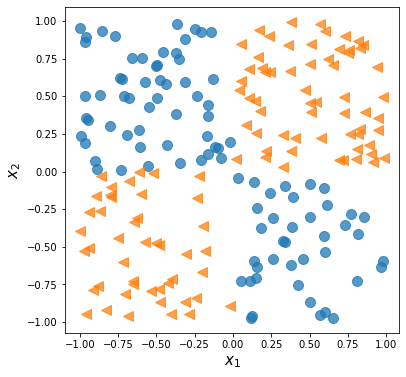

In [16]:
np.random.seed(1)
torch.manual_seed(1)
x = np.random.uniform(low=-1, high=1, size=(200, 2))
y = np.ones(len(x))
y[x[:, 0] * x[:, 1] < 0] = 0

n_train = 100
x_train = torch.tensor(x[:n_train, :], dtype=torch.float32)
y_train = torch.tensor(y[:n_train], dtype=torch.float32)
x_valid = torch.tensor(x[n_train:, :], dtype=torch.float32)
y_valid = torch.tensor(y[n_train:], dtype=torch.float32)

_, ax = plt.subplots(figsize=(6, 4))

ax.plot(x[y == 0, 0], x[y == 0, 1], 'o', alpha=0.75, markersize=10)
ax.plot(x[y == 1, 0], x[y == 1, 1], '<', alpha=0.75, markersize=10)
ax.set_xlabel(r'$x_1$', size=15)
ax.set_ylabel(r'$x_2$', size=15)
plt.show()

In [17]:
from torch.utils.data import DataLoader, TensorDataset

train_ds = TensorDataset(x_train, y_train)
batch_size = 2
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [18]:
model = nn.Sequential(nn.Linear(2, 1), nn.Sigmoid())
model

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)

In [19]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [20]:
torch.manual_seed(1)
num_epochs = 200


def train(model, num_epochs, train_dl, x_valid, y_valid):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()
            is_correct = ((pred >= 0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.mean()

        loss_hist_train[epoch] /= n_train / batch_size
        accuracy_hist_train[epoch] /= n_train / batch_size

        pred = model(x_valid)[:, 0]
        loss = loss_fn(pred, y_valid)
        loss_hist_valid[epoch] = loss.item()
        is_correct = ((pred >= 0.5).float() == y_valid).float()
        accuracy_hist_valid[epoch] += is_correct.mean()
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid


history = train(model, num_epochs, train_dl, x_valid, y_valid)

Text(0.5, 0, 'Epochs')

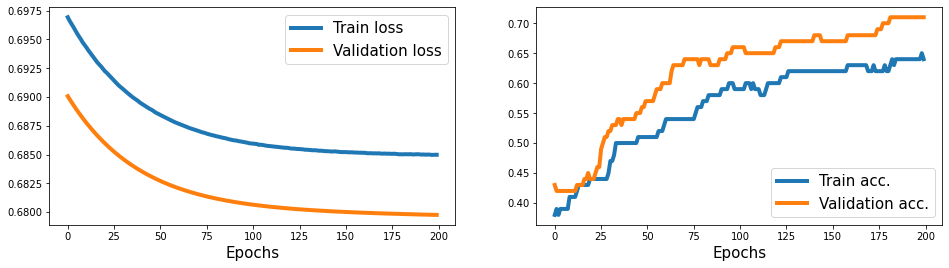

In [21]:
_, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

axes[0].plot(history[0], lw=4)
axes[0].plot(history[1], lw=4)
axes[0].legend(['Train loss', 'Validation loss'], fontsize=15)
axes[0].set_xlabel('Epochs', size=15)

axes[1].plot(history[2], lw=4)
axes[1].plot(history[3], lw=4)
axes[1].legend(['Train acc.', 'Validation acc.'], fontsize=15)
axes[1].set_xlabel('Epochs', size=15)

In [22]:
model = nn.Sequential(nn.Linear(2, 4), nn.ReLU(), nn.Linear(4, 4), nn.ReLU(),
                      nn.Linear(4, 1), nn.Sigmoid())

loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)

model


Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
  (5): Sigmoid()
)

In [23]:
history = train(model, num_epochs, train_dl, x_valid, y_valid)


Text(0.5, 0, 'Epochs')

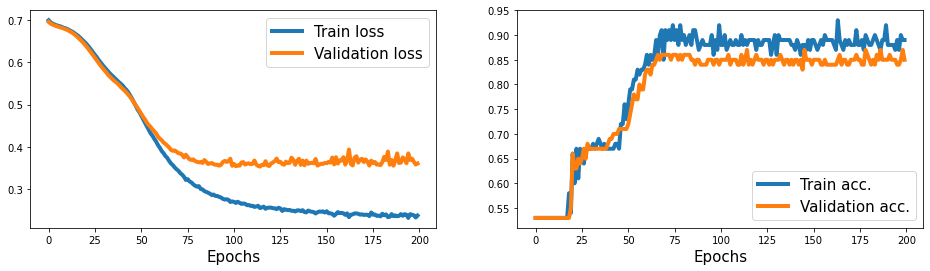

In [24]:
_, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

axes[0].plot(history[0], lw=4)
axes[0].plot(history[1], lw=4)
axes[0].legend(['Train loss', 'Validation loss'], fontsize=15)
axes[0].set_xlabel('Epochs', size=15)

axes[1].plot(history[2], lw=4)
axes[1].plot(history[3], lw=4)
axes[1].legend(['Train acc.', 'Validation acc.'], fontsize=15)
axes[1].set_xlabel('Epochs', size=15)

## Making model building more flexible with nn.Module


In [25]:
class MyModule(nn.Module):

    def __init__(self):
        super().__init__()
        l1 = nn.Linear(2, 4)
        a1 = nn.ReLU()
        l2 = nn.Linear(4, 4)
        a2 = nn.ReLU()
        l3 = nn.Linear(4, 1)
        a3 = nn.Sigmoid()
        l = [l1, a1, l2, a2, l3, a3]
        self.module_list = nn.ModuleList(l)

    def forward(self, x):
        for f in self.module_list:
            x = f(x)
        return x

    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred >= 0.5).float()


model = MyModule()
model

MyModule(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [26]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)

# torch.manual_seed(1)
history = train(model, num_epochs, train_dl, x_valid, y_valid)

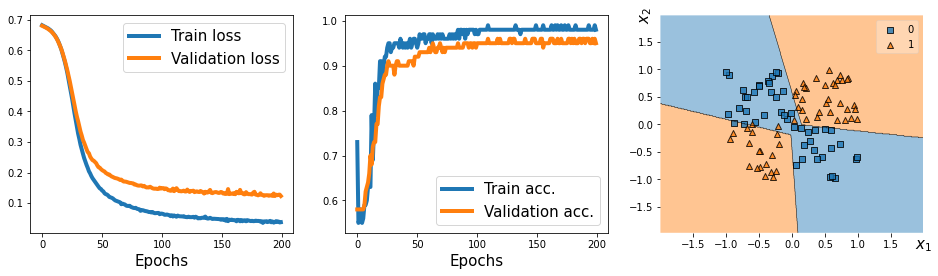

In [27]:
from mlxtend.plotting import plot_decision_regions

_, axes = plt.subplots(1, 3, figsize=(10, 4), constrained_layout=True)
axes[0].plot(history[0], lw=4)
axes[0].plot(history[1], lw=4)
axes[0].legend(['Train loss', 'Validation loss'], fontsize=15)
axes[0].set_xlabel('Epochs', size=15)

axes[1].plot(history[2], lw=4)
axes[1].plot(history[3], lw=4)
axes[1].legend(['Train acc.', 'Validation acc.'], fontsize=15)
axes[1].set_xlabel('Epochs', size=15)

plot_decision_regions(X=x_valid.numpy(),
                      y=y_valid.numpy().astype(np.int64),
                      clf=model,
                      ax=ax)
axes[2].set_xlabel(r'$x_1$', size=15)
axes[2].xaxis.set_label_coords(1, -0.025)
axes[2].set_ylabel(r'$x_2$', size=15)
axes[2].yaxis.set_label_coords(-0.025, 1)
plt.show()

## Writing custom layers in PyTorch


In [28]:
class NoisyLinear(nn.Module):

    def __init__(self, input_size, output_size, noise_stddev=0.1):
        super().__init__()
        w = torch.Tensor(input_size, output_size)
        self.w = nn.Parameter(
            w)  # nn.Parameter is a Tensor that's a module parameter.
        nn.init.xavier_uniform_(self.w)
        b = torch.Tensor(output_size).fill_(0)
        self.b = nn.Parameter(b)
        self.noise_stddev = noise_stddev

    def forward(self, x, training=False):
        if training:
            noise = torch.normal(0.0, self.noise_stddev, x.shape)
            x_new = torch.add(x, noise)
        else:
            x_new = x
        return torch.add(torch.mm(x_new, self.w), self.b)

In [29]:
## testing:
torch.manual_seed(1)
noisy_layer = NoisyLinear(4, 2)
x = torch.zeros((1, 4))

print(noisy_layer(x, training=True))
print(noisy_layer(x, training=True))
print(noisy_layer(x, training=False))

tensor([[ 0.1154, -0.0598]], grad_fn=<AddBackward0>)
tensor([[ 0.0432, -0.0375]], grad_fn=<AddBackward0>)
tensor([[0., 0.]], grad_fn=<AddBackward0>)


In [30]:
class MyNoisyModule(nn.Module):

    def __init__(self):
        super().__init__()
        self.l1 = NoisyLinear(2, 4, 0.07)
        self.a1 = nn.ReLU()
        self.l2 = nn.Linear(4, 4)
        self.a2 = nn.ReLU()
        self.l3 = nn.Linear(4, 1)
        self.a3 = nn.Sigmoid()

    def forward(self, x, training=False):
        x = self.l1(x, training)
        x = self.a1(x)
        x = self.l2(x)
        x = self.a2(x)
        x = self.l3(x)
        x = self.a3(x)
        return x

    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred >= 0.5).float()


torch.manual_seed(1)
model = MyNoisyModule()
model

MyNoisyModule(
  (l1): NoisyLinear()
  (a1): ReLU()
  (l2): Linear(in_features=4, out_features=4, bias=True)
  (a2): ReLU()
  (l3): Linear(in_features=4, out_features=1, bias=True)
  (a3): Sigmoid()
)

In [31]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)

torch.manual_seed(1)

loss_hist_train = [0] * num_epochs
accuracy_hist_train = [0] * num_epochs
loss_hist_valid = [0] * num_epochs
accuracy_hist_valid = [0] * num_epochs

for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch, True)[:, 0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist_train[epoch] += loss.item()
        is_correct = ((pred >= 0.5).float() == y_batch).float()
        accuracy_hist_train[epoch] += is_correct.mean()

    loss_hist_train[epoch] /= n_train / batch_size
    accuracy_hist_train[epoch] /= n_train / batch_size

    pred = model(x_valid)[:, 0]
    loss = loss_fn(pred, y_valid)
    loss_hist_valid[epoch] = loss.item()
    is_correct = ((pred >= 0.5).float() == y_valid).float()
    accuracy_hist_valid[epoch] += is_correct.mean()

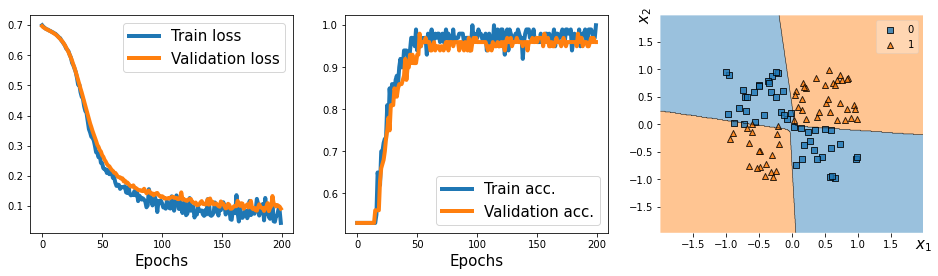

In [32]:
from mlxtend.plotting import plot_decision_regions

_, axes = plt.subplots(1, 3, figsize=(12, 6), constrained_layout=True)

axes[0].plot(loss_hist_train, lw=4)
axes[0].plot(loss_hist_valid, lw=4)
axes[0].legend(['Train loss', 'Validation loss'], fontsize=15)
axes[0].set_xlabel('Epochs', size=15)

axes[1].plot(accuracy_hist_train, lw=4)
axes[1].plot(accuracy_hist_valid, lw=4)
axes[1].legend(['Train acc.', 'Validation acc.'], fontsize=15)
axes[1].set_xlabel('Epochs', size=15)

plot_decision_regions(X=x_valid.numpy(),
                      y=y_valid.numpy().astype(np.int64),
                      clf=model, ax=ax)
axes[2].set_xlabel(r'$x_1$', size=15)
axes[2].xaxis.set_label_coords(1, -0.025)
axes[2].set_ylabel(r'$x_2$', size=15)
axes[2].yaxis.set_label_coords(-0.025, 1)
plt.show()

## Project one - predicting the fuel efficiency of a car


### Working with feature columns


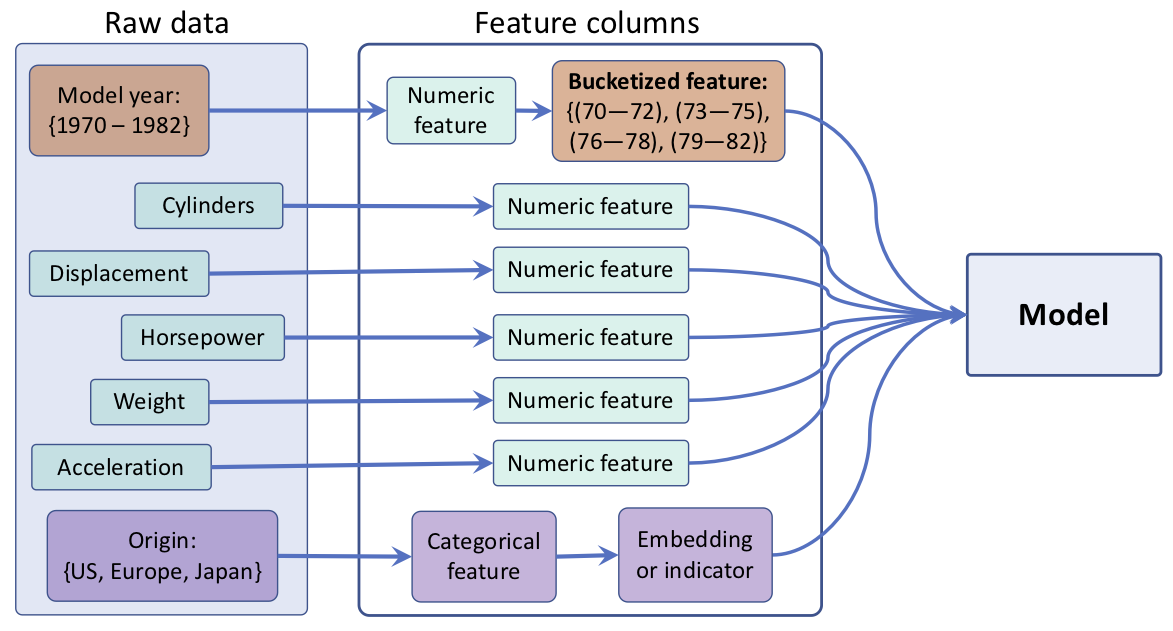

In [33]:
Image(filename='figures/13_07.png', width=700)

In [34]:
column_names = [
    'MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration',
    'Model Year', 'Origin'
]

df = pd.read_csv('../../datasets/stats/auto_mpg.data',
                 names=column_names,
                 na_values="?",
                 comment='\t',
                 sep=" ",
                 skipinitialspace=True)

df.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [35]:
print(df.isna().sum())

df = df.dropna()
df = df.reset_index(drop=True)
df.tail()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
387,27.0,4,140.0,86.0,2790.0,15.6,82,1
388,44.0,4,97.0,52.0,2130.0,24.6,82,2
389,32.0,4,135.0,84.0,2295.0,11.6,82,1
390,28.0,4,120.0,79.0,2625.0,18.6,82,1
391,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [36]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, train_size=0.8, random_state=1)
train_stats = df_train.describe().transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
MPG,313.0,23.404153,7.666909,9.0,17.5,23.0,29.0,46.6
Cylinders,313.0,5.402556,1.701506,3.0,4.0,4.0,8.0,8.0
Displacement,313.0,189.512780,102.675646,68.0,104.0,140.0,260.0,455.0
Horsepower,313.0,102.929712,37.919046,46.0,75.0,92.0,120.0,230.0
Weight,313.0,2961.198083,848.602146,1613.0,2219.0,2755.0,3574.0,5140.0
Acceleration,313.0,15.704473,2.725399,8.5,14.0,15.5,17.3,24.8
Model Year,313.0,75.929712,3.675305,70.0,73.0,76.0,79.0,82.0
Origin,313.0,1.591054,0.807923,1.0,1.0,1.0,2.0,3.0


In [37]:
numeric_column_names = [
    'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration'
]

df_train_norm, df_test_norm = df_train.copy(), df_test.copy()

for col_name in numeric_column_names:
    mean = train_stats.loc[col_name, 'mean']
    std = train_stats.loc[col_name, 'std']
    df_train_norm.loc[:,
                      col_name] = (df_train_norm.loc[:, col_name] - mean) / std
    df_test_norm.loc[:,
                     col_name] = (df_test_norm.loc[:, col_name] - mean) / std

df_train_norm.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
203,28.0,-0.824303,-0.901020,-0.736562,-0.950031,0.255202,76,3
255,19.4,0.351127,0.413800,-0.340982,0.293190,0.548737,78,1
72,13.0,1.526556,1.144256,0.713897,1.339617,-0.625403,72,1
235,30.5,-0.824303,-0.891280,-1.053025,-1.072585,0.475353,77,1
37,14.0,1.526556,1.563051,1.636916,1.470420,-1.359240,71,1


In [38]:
boundaries = torch.tensor([73, 76, 79])

v = torch.tensor(df_train_norm['Model Year'].values)
df_train_norm['Model Year Bucketed'] = torch.bucketize(v,
                                                       boundaries,
                                                       right=True)

v = torch.tensor(df_test_norm['Model Year'].values)
df_test_norm['Model Year Bucketed'] = torch.bucketize(v,
                                                      boundaries,
                                                      right=True)

numeric_column_names.append('Model Year Bucketed')

In [39]:
from torch.nn.functional import one_hot

total_origin = len(set(df_train_norm['Origin']))

origin_encoded = one_hot(
    torch.from_numpy(df_train_norm['Origin'].values) % total_origin)
x_train_numeric = torch.tensor(df_train_norm[numeric_column_names].values)
x_train = torch.cat([x_train_numeric, origin_encoded], 1).float()

origin_encoded = one_hot(
    torch.from_numpy(df_test_norm['Origin'].values) % total_origin)
x_test_numeric = torch.tensor(df_test_norm[numeric_column_names].values)
x_test = torch.cat([x_test_numeric, origin_encoded], 1).float()


In [40]:
y_train = torch.tensor(df_train_norm['MPG'].values).float()
y_test = torch.tensor(df_test_norm['MPG'].values).float()

In [41]:
from torch.utils.data import DataLoader, TensorDataset

train_ds = TensorDataset(x_train, y_train)
batch_size = 8
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [42]:
hidden_units = [8, 4]
input_size = x_train.shape[1]

all_layers = []
for hidden_unit in hidden_units:
    layer = nn.Linear(input_size, hidden_unit)
    all_layers.append(layer)
    all_layers.append(nn.ReLU())
    input_size = hidden_unit

all_layers.append(nn.Linear(hidden_units[-1], 1))

model = nn.Sequential(*all_layers)

model

Sequential(
  (0): Linear(in_features=9, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
)

In [43]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [44]:
torch.manual_seed(1)
num_epochs = 200
log_epochs = 20
for epoch in range(num_epochs):
    loss_hist_train = 0
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)[:, 0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist_train += loss.item()
    if epoch % log_epochs == 0:
        print(f'Epoch {epoch}  Loss {loss_hist_train/len(train_dl):.4f}')


Epoch 0  Loss 536.1047
Epoch 20  Loss 8.4361
Epoch 40  Loss 7.8695
Epoch 60  Loss 7.1891
Epoch 80  Loss 6.7064
Epoch 100  Loss 6.7603
Epoch 120  Loss 6.3107
Epoch 140  Loss 6.6884
Epoch 160  Loss 6.7549
Epoch 180  Loss 6.2029


In [45]:
with torch.no_grad():
    pred = model(x_test.float())[:, 0]
    loss = loss_fn(pred, y_test)
    print(f'Test MSE: {loss.item():.4f}')
    print(f'Test MAE: {nn.L1Loss()(pred, y_test).item():.4f}')

Test MSE: 9.5907
Test MAE: 2.1177


## Project two - classifying MNIST hand-written digits


In [46]:
import torchvision
from torchvision import transforms, datasets

image_path = '../../datasets/torch'
transform = transforms.Compose([transforms.ToTensor()])

mnist_train_dataset = datasets.MNIST(root=image_path,
                                     train=True,
                                     transform=transform,
                                     download=True)
mnist_test_dataset = datasets.MNIST(root=image_path,
                                    train=False,
                                    transform=transform,
                                    download=False)

batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)

In [47]:
hidden_units = [32, 16]
image_size = mnist_train_dataset[0][0].shape
input_size = image_size[0] * image_size[1] * image_size[2]

all_layers = [nn.Flatten()]
for hidden_unit in hidden_units:
    layer = nn.Linear(input_size, hidden_unit)
    all_layers.append(layer)
    all_layers.append(nn.ReLU())
    input_size = hidden_unit

all_layers.append(nn.Linear(hidden_units[-1], 10))
model = nn.Sequential(*all_layers)

model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=32, bias=True)
  (2): ReLU()
  (3): Linear(in_features=32, out_features=16, bias=True)
  (4): ReLU()
  (5): Linear(in_features=16, out_features=10, bias=True)
)

In [48]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

torch.manual_seed(1)
num_epochs = 20
for epoch in range(num_epochs):
    accuracy_hist_train = 0
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist_train += is_correct.sum()
    accuracy_hist_train /= len(train_dl.dataset)
    print(f'Epoch {epoch}  Accuracy {accuracy_hist_train:.4f}')

Epoch 0  Accuracy 0.8531
Epoch 1  Accuracy 0.9287
Epoch 2  Accuracy 0.9413
Epoch 3  Accuracy 0.9506
Epoch 4  Accuracy 0.9558
Epoch 5  Accuracy 0.9592
Epoch 6  Accuracy 0.9627
Epoch 7  Accuracy 0.9650
Epoch 8  Accuracy 0.9674
Epoch 9  Accuracy 0.9690
Epoch 10  Accuracy 0.9710
Epoch 11  Accuracy 0.9729
Epoch 12  Accuracy 0.9739
Epoch 13  Accuracy 0.9750
Epoch 14  Accuracy 0.9764
Epoch 15  Accuracy 0.9777
Epoch 16  Accuracy 0.9779
Epoch 17  Accuracy 0.9798
Epoch 18  Accuracy 0.9807
Epoch 19  Accuracy 0.9813


In [49]:
pred = model(mnist_test_dataset.data / 255.)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}')

Test accuracy: 0.9653
